In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import random
%matplotlib inline

In [59]:
def f(x):
  return 4*x**2 + 3*x + 5

In [60]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
ys

array([ 90. ,  81. ,  72.5,  64.5,  57. ,  50. ,  43.5,  37.5,  32. ,
        27. ,  22.5,  18.5,  15. ,  12. ,   9.5,   7.5,   6. ,   5. ,
         4.5,   4.5,   5. ,   6. ,   7.5,   9.5,  12. ,  15. ,  18.5,
        22.5,  27. ,  32. ,  37.5,  43.5,  50. ,  57. ,  64.5,  72.5,
        81. ,  90. ,  99.5, 109.5])

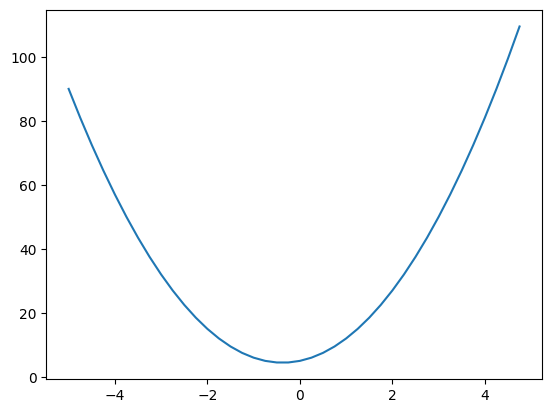

In [61]:
plt.plot(xs,ys)

## derivative intuition

In [62]:
print(f(3))

50


In [63]:
h = 0.0001
print((f(3+h)-f(3))/h) # after derivatin it becomes 8x + 3

27.000400000076752


## Creating custom variable

In [64]:
class Value:
  def __init__(self,data):
    self.data = data
    self.grad = 0.0

  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self,other):
    return self.data + other.data

  def __mul__(self,other):
    return self.data * other.data



In [65]:
a = Value(2.0)
b = Value(3.0)

In [66]:
a.__repr__()

'value(data=2.0)'

In [67]:
print(a)

value(data=2.0)


##

In [68]:
c = a*b
print(c)

6.0


## Creating expression pointers

In [69]:
class Value:
  def __init__(self,data,_child=(),_op='',label=''):
    self.data = data
    self.grad = 0.0
    self._prev = set(_child)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self,other):
    out =  Value(self.data + other.data,(self,other),_op='+')
    return out

  def __mul__(self,other):
    out = Value(self.data * other.data,(self,other),_op='*')
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t,(self,),_op='tanh')
    return out



In [70]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0,label='f')
L = d * f; L.label = 'L'
L

value(data=-8.0)

In [71]:
print(d._prev)
print(d._op)

{value(data=10.0), value(data=-6.0)}
+


In [72]:
from graphviz import Digraph

def trace(root):
  nodes,edges = set(),set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dpt = Digraph(format='svg',graph_attr={'rankdir':'LR'})

  nodes,edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dpt.node(name=uid,label="{%s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad),shape='record')
    if n._op:
      dpt.node(name=uid+n._op,label=n._op)
      dpt.edge(uid+n._op,uid)

  for n1,n2 in edges:
    dpt.edge(str(id(n1)),str(id(n2))+n2._op)
  return dpt


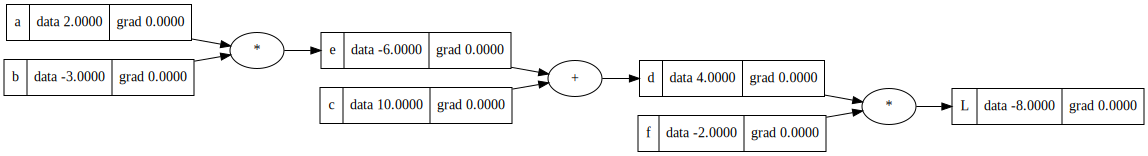

In [73]:
draw_dot(L)

##Manual backpropagation

In [74]:
def lol():

  h = 0.001

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0,label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0,label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h

  print((L2 - L1)/h)


lol()

1.000000000000334


In [75]:
L.grad = 1.0

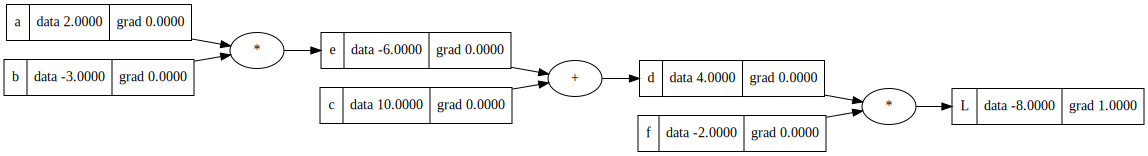

In [76]:
draw_dot(L)

In [77]:
""" L = d * f
    dL/dd = f and dL/df = d"""

""" (f(x+h)-f(x))/h
    ((d+h)*f -d*f)/h = f """

d.grad = -2.0
f.grad = 4

#verification
def lol():

  h = 0.001

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0,label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0,label='a')
  b = Value(-3.0,label='b')
  c = Value(10.0,label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  d.data += h
  f = Value(-2.0,label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)


lol()


-2.000000000000668


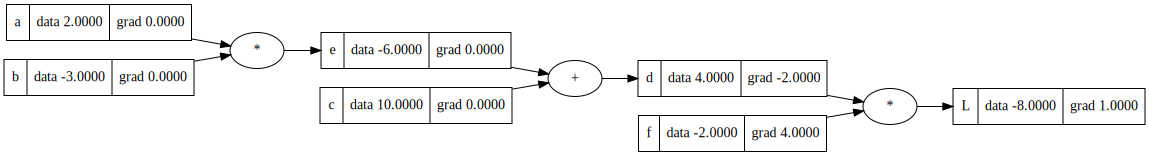

In [78]:
draw_dot(L)

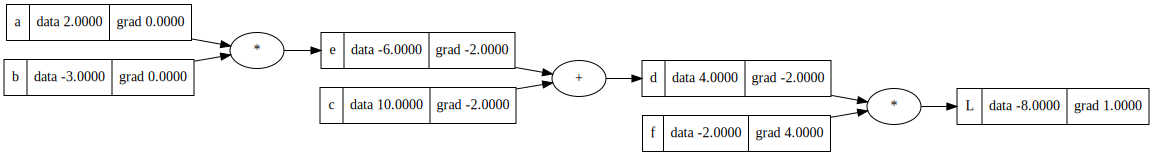

In [79]:
"""
  dL/dc = ?
  dL/de = ?

  'L' depends on 'd' and 'd' depends on 'c'

  dL/dc = dL/dd * dd/dc (chain rule)

  dd/dc = 1.0
  dd/de = 1.0

  dL/dc = dL/dd
  dL/de = dL/dd
"""
c.grad = -2.0
e.grad = -2.0

draw_dot(L)

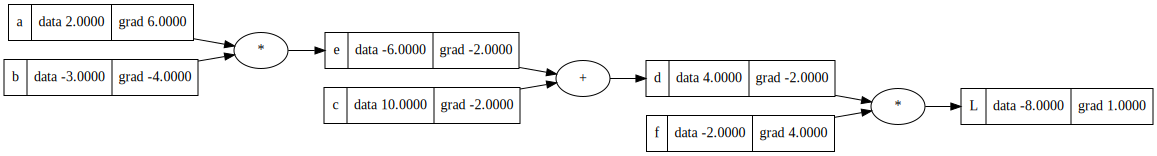

In [80]:
"""
  dL/da =?
  dL/db =?

  e = a*b i.e de/da = b and de/db = a

"""
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

draw_dot(L)




In [81]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


## Backpropagation through neuron

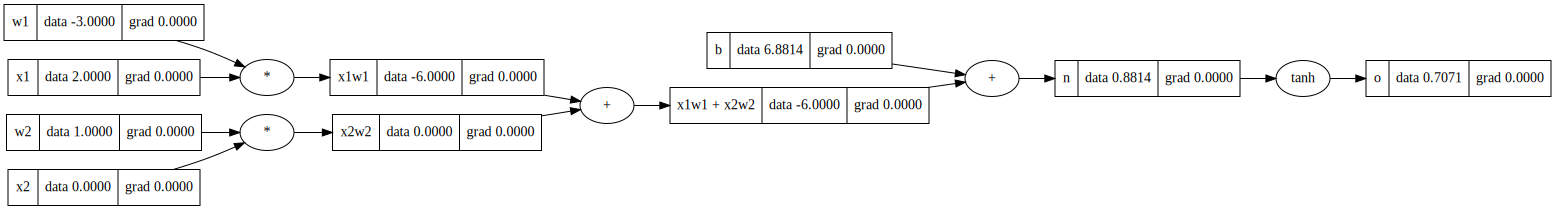

In [82]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)


In [83]:
#base case
o.grad = 1.0

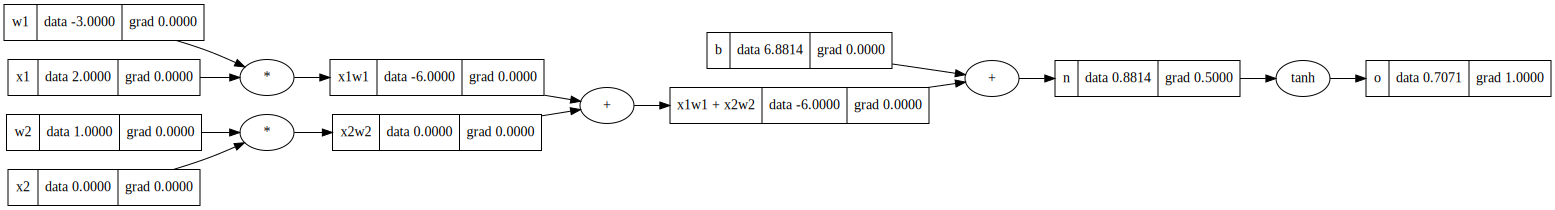

In [84]:
"""
  o = tanh(n)
  do/dn = 1 - tanh(n)**2

"""
n.grad = 1 - o.data**2
draw_dot(o)

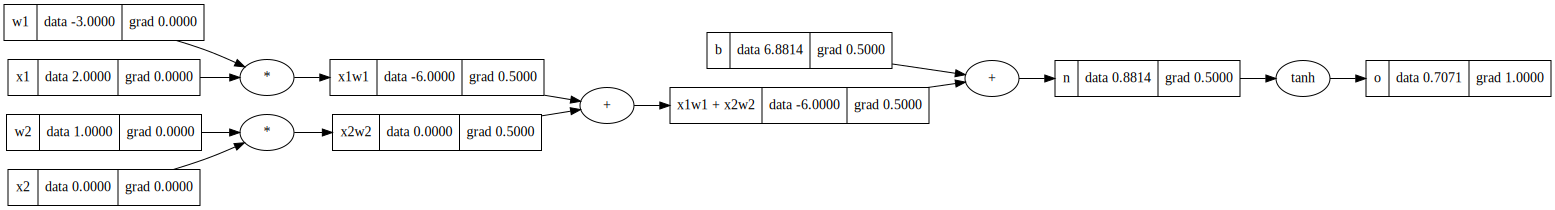

In [85]:
#Due to addition operation
b.grad = n.grad
x1w1x2w2.grad = n.grad

x1w1.grad = n.grad
x2w2.grad = n.grad

draw_dot(o)

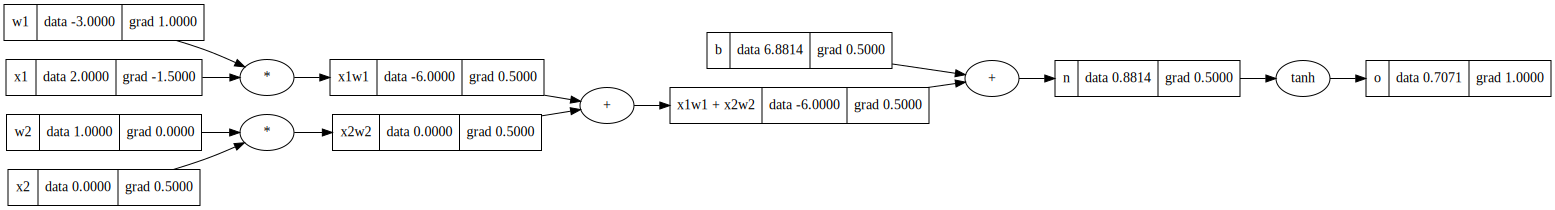

In [86]:
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad

draw_dot(o)

## Automating backward

In [103]:
class Value:
  def __init__(self,data,_child=(),_op='',label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_child)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out =  Value(self.data + other.data,(self,other),_op='+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __sub__(self,other):
    return self + (-other)

  def __neg__(self):
    return self*-1

  def __mul__(self,other):
      other  = other if isinstance(other,Value) else Value(other)

      out = Value(self.data * other.data,(self,other),'*')

      def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
      out._backward = _backward

      return out

  def __rmul__(self,other):
    return self*other

  def __truediv__(self,other):
    return self * other**-1

  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only int/float supported"
    out = Value(self.data**other,(self,),f'**{other}')

    def _backward():
      self.grad += other*(self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    n = self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t,(self,),_op='tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    out = Value(math.exp(self.data),(self,),'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



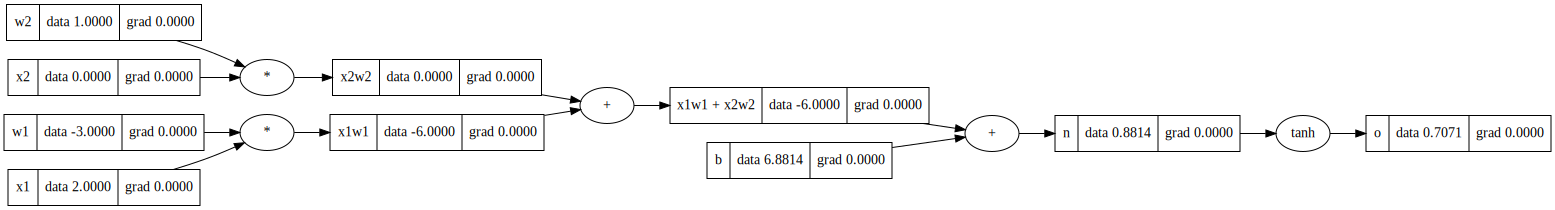

In [106]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [89]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
w1._backward()
w2._backward()

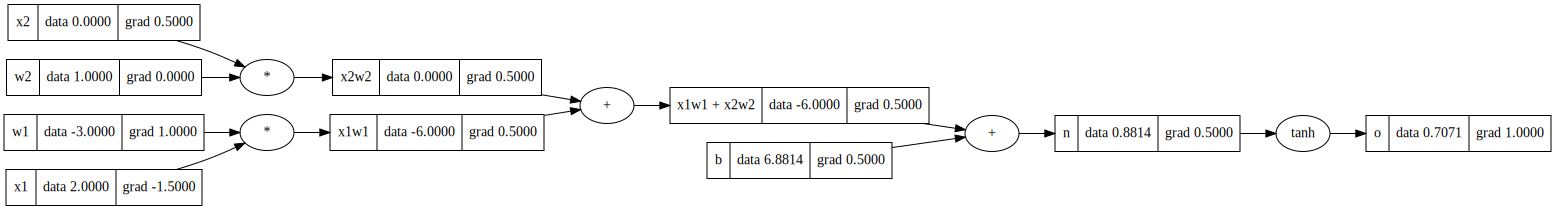

In [90]:

draw_dot(o)

In [91]:
# implementing topological sort to avoid calling backward again n again
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[value(data=2.0),
 value(data=-3.0),
 value(data=-6.0),
 value(data=0.0),
 value(data=1.0),
 value(data=0.0),
 value(data=-6.0),
 value(data=6.881373587019543),
 value(data=0.8813735870195432),
 value(data=0.7071067811865476)]

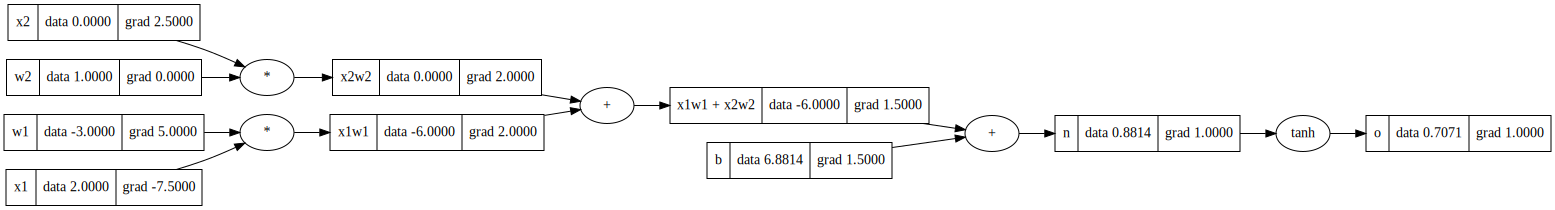

In [92]:
# add this in value class
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

for node in reversed(topo):
  node._backward()

draw_dot(o)

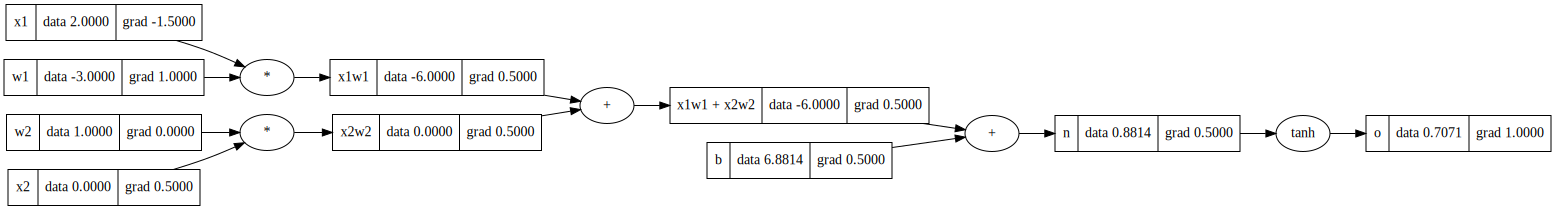

In [105]:
# Testing the backward

o.backward()
draw_dot(o)

##Breaking tanh

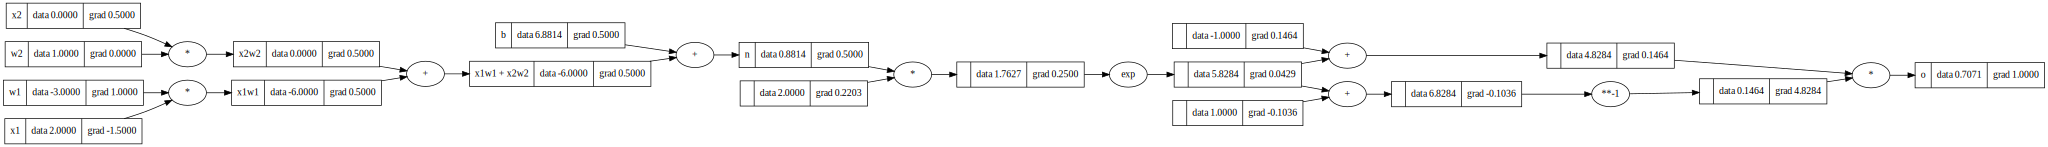

In [107]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')

w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

##Doing same thing in pytorch

In [108]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


##Building Neural Network

In [119]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [124]:
x = [2.0 ,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

value(data=0.7694881105095284)

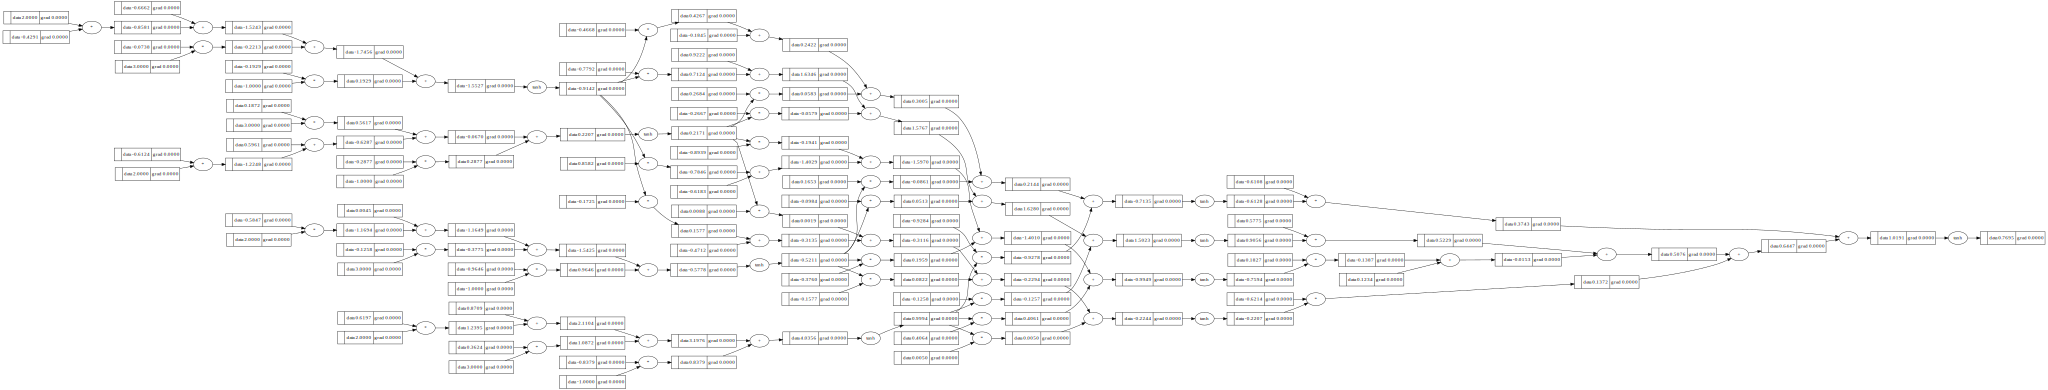

In [125]:
draw_dot(n(x))

In [128]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[value(data=0.7694881105095284),
 value(data=0.8533500207102992),
 value(data=0.7139289124751087),
 value(data=0.7620672360797078)]

In [131]:
import numpy as np

for k in range(50):
  ypred = [n(x) for x in xs]
  loss = np.sum(np.array([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)]))

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k,loss.data)


0 0.007885598879424449
1 0.0077008309794885585
2 0.0075246922800848845
3 0.007356573565409329
4 0.007195923406926156
5 0.007042241292491803
6 0.006895071732357247
7 0.006753999181519697
8 0.006618643647627428
9 0.006488656877283104
10 0.0063637190325020005
11 0.006243535784295007
12 0.006127835762651119
13 0.006016368312198962
14 0.005908901511000373
15 0.0058052204166402655
16 0.005705125509309282
17 0.005608431306159758
18 0.0055149651250257165
19 0.00542456597878
20 0.0053370835842691915
21 0.005252377472009382
22 0.005170316184721094
23 0.00509077655438392
24 0.005013643048856917
25 0.004938807180270387
26 0.0048661669683902325
27 0.00479562645300652
28 0.004727095250131675
29 0.0046604881474243895
30 0.004595724734802259
31 0.004532729066679059
32 0.004471429352673525
33 0.004411757673995375
34 0.0043536497230258955
35 0.004297044563884546
36 0.004241884412012393
37 0.00418811443101388
38 0.0041356825451834564
39 0.0040845392663075575
40 0.004034637533476376
41 0.00398593256476772

In [132]:
ypred

[value(data=0.968661550272176),
 value(data=-0.9733510090274601),
 value(data=-0.972393679685203),
 value(data=0.9656448234007021)]

In [134]:
ys

[1.0, -1.0, -1.0, 1.0]